<a href="https://colab.research.google.com/github/Helyousfi/DL---NST-project/blob/main/DL_NST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Helyousfi/DL---NST-project.git

fatal: destination path 'DL---NST-project' already exists and is not an empty directory.


### Step 1 : Loading VGG Pretrained Model

In [ ]:
import torch
from torchvision import models
vgg = models.vgg19(pretrained = True)
vgg = vgg.features
#print(vgg)

In [ ]:
for parameters in vgg.parameters():
  parameters.requires_grad_(False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Step 2 : Preprocess image

In [ ]:
from PIL import Image
from torchvision import transforms as T

def preprocess(img_path, max_size = 500):
  image = Image.open(img_path)
  if max(image.size) > max_size:
      size = max_size
  else:
      size = max(image.size)
  img_transforms = T.Compose([
                              T.Resize(size),
                              T.ToTensor(), #(244,244,3) -> (3,244,244)
                              T.Normalize(
                                  mean = [0.485, 0.456, 0.406],
                                  std = [0.229, 0.224, 0.225]
                              )
  ])
  image = img_transforms(image)
  image = image.unsqueeze(0) #(3,244,244) -> (1,3,244,244)
  return image

In [ ]:
Content_p = preprocess('/content/DL---NST-project/Project-NST-main/Project-NST-main/content11.jpg')
Style_p = preprocess('/content/style.jpg')

Content_p = Content_p.to(device)
Style_p = Style_p.to(device)

print("Content shape", Content_p.shape)
print("Style shape", Style_p.shape)

Content shape torch.Size([1, 3, 259, 345])
Style shape torch.Size([1, 3, 222, 410])


### Step 3 : Deprocess the image

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 

def deprocess(tensor):
  image = tensor.to('cpu').clone()
  image = image.numpy()
  image = image.squeeze(0) #(1,3,244,244) -> (3,244,244)
  image = image.transpose(1,2,0) #(3,244,244) - > (244,244,3)
  image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
  image = image.clip(0,1)
  return image 

In [ ]:
Content_d = deprocess(Content_p)
Style_d = deprocess(Style_p)

print("Content shape", Content_d.shape)
print("Style shape", Style_d.shape)

Content shape (259, 345, 3)
Style shape (222, 410, 3)


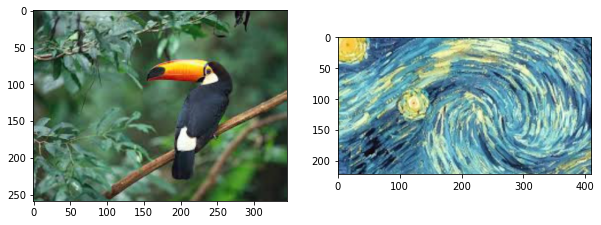

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,10))
ax1.imshow(Content_d)
ax2.imshow(Style_d)

### Step 4 : Get Content Loss, Style features and create gram matrix

In [ ]:
def get_features(image, model):
  layers = {
      '0' : 'conv1_1',
      '5' : 'conv2_1', 
      '10' : 'conv3_1',
      '19' : 'conv4_1', 
      '21' : 'conv4_2', #Content feauture
      '28' : 'conv5_1'      
  }

  Features = {}

  x = image

  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers :
      Features[layers[name]] = x
  
  return Features

In [ ]:
Content_f = get_features(Content_p, vgg)
Style_f = get_features(Style_p, vgg)

for layer in Style_f:
  print(Style_f[layer].shape)
  break

torch.Size([1, 64, 222, 410])


In [ ]:
def gram_matrix(tensor):
  b,c,h,w = tensor.size()
  tensor = tensor.view(c,h*w)
  gram = torch.mm(tensor, tensor.t())
  return gram


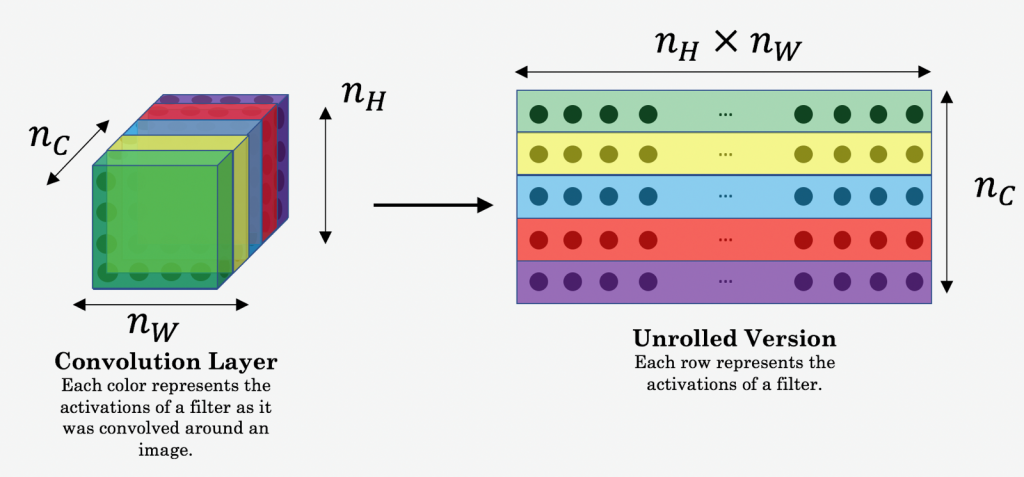

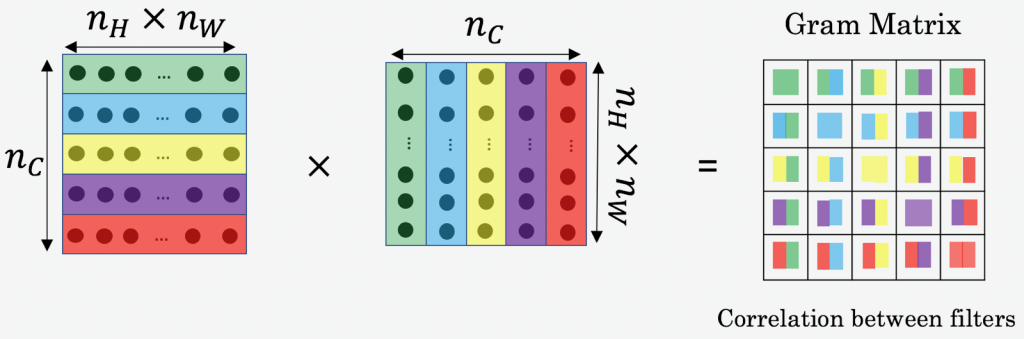

In [ ]:
style_grams = {layer : gram_matrix(Style_f[layer]) for layer in Style_f}

### Creating style and content loss function

In [ ]:
def content_loss(target_conv4_2, content_conv4_2):
  loss = torch.mean((target_conv4_2 - content_conv4_2)**2)
  return loss

In [ ]:
style_weights = {
    'conv1_1' : 1.0,
    'conv2_1' : 0.75,
    'conv3_1' : 0.2,
    'conv4_1' : 0.2,
    'conv5_1' : 0.2
}

In [ ]:
def style_loss(style_weights, target_features, style_grams):
  loss = 0
  for layer in style_weights:
    target_f = target_features[layer]
    target_gram = gram_matrix(target_f)
    style_gram = style_grams[layer]

    b,c,h,w = target_f.shape 
    layer_loss = style_weights[layer]*torch.mean((target_gram-style_gram)**2)
    loss += layer_loss/(c*h*w)

  return loss

In [ ]:
target = Content_p.clone().requires_grad_(True).to(device)
target_f = get_features(target, vgg)
print("content loss : ", content_loss(target_f['conv4_2'], Content_f['conv4_2']))
print("style loss : ", style_loss(style_weights, target_f, style_grams))

content loss :  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
style loss :  tensor(102.9131, device='cuda:0', grad_fn=<AddBackward0>)


### Step 6 : training loop

In [ ]:
from torch import optim
optimiser = optim.Adam([target], lr=0.03)

alpha = 1
beta = 1e5

epochs = 3000
show_every = 500

In [ ]:
def total_loss(content_loss, style_loss, alpha, beta):
  loss = alpha*content_loss + beta*style_loss
  return loss

In [ ]:
results = []
for i in range(epochs):
  target_f = get_features(target, vgg)
  c_loss = content_loss(target_f['conv4_2'], Content_f['conv4_2'])
  s_loss = style_loss(style_weights, target_f, style_grams)
  t_loss = total_loss(c_loss, s_loss, alpha, beta)

  optimiser.zero_grad()
  t_loss.backward()
  optimiser.step()

  if i%show_every == 0:
    print("Total loss at epoch {} : {}".format(i, t_loss))
    results.append(deprocess(target.detach()))

Total loss at epoch 0 : 10291314.0
Total loss at epoch 500 : 21297.337890625
Total loss at epoch 1000 : 6905.12939453125
Total loss at epoch 1500 : 4158.44873046875
Total loss at epoch 2000 : 3102.278564453125
Total loss at epoch 2500 : 2573.197021484375


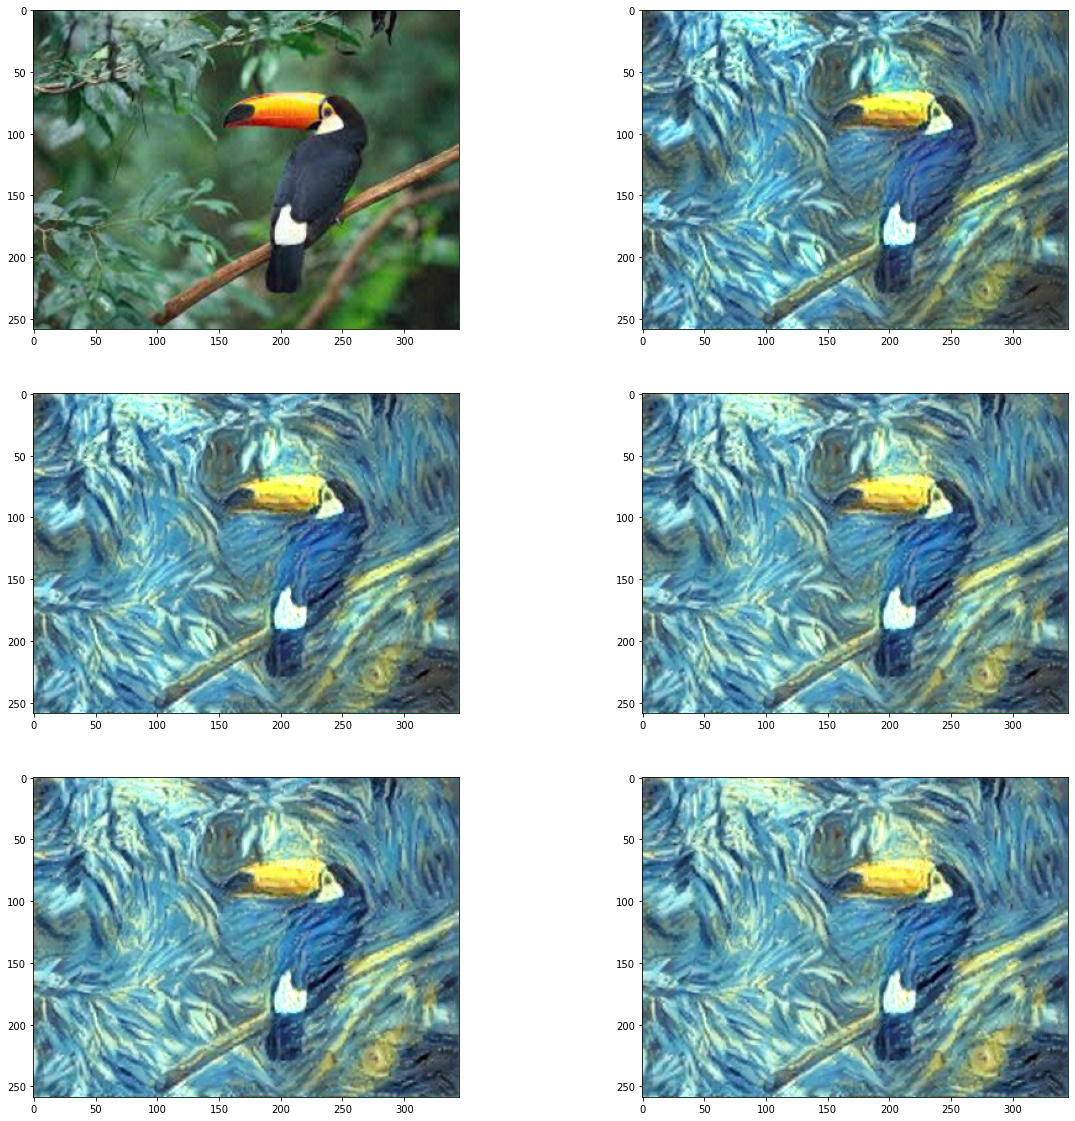

In [ ]:
plt.figure(figsize = (20,20))
for i in range(len(results)):
  plt.subplot(3,2,i+1)
  plt.imshow(results[i])
plt.show()